**Extracting diagnostic information on species growth!**
Method: 
1) TRAIN the model on all data from the census.
2) For each species present, create a dataset where all the trees are of that one species and every DBH from 10 to 500 is represented.
3) Use this dataset as a test set.
4) Instead of calculating a loss function, plot the output as a function of the DBH input!

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import category_encoders as ce
import xgboost as xgb
import matplotlib.pyplot as mpl
import data_processing
import importlib

In [ ]:
# attempt to use data processing script! - DO NOT RUN UNTIL DEBUGGED!!
importlib.reload(data_processing)
paths = ("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1985.csv","/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1990.csv")
feats, labels, test_ids, test_feats = data_processing.clean(paths, num_quads=400)


Run the below instead of the preprocessing file for now!!

In [2]:
# load all data, using just the 1985 to 1990 data to train for now
t1 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1985.csv")
t2 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1990.csv")

# simplify columns and column names
expected_labels = t2[['treeID', 'dbh']]
expected_labels = expected_labels.rename(columns={"dbh": "dbh2", "treeID": "treeID2"})
featurest1 = t1[['treeID', 'sp', 'dbh']]
featurest1 = featurest1.rename(columns={"dbh": "dbh1", "treeID":"treeID1"})

# encode the species into binary features and drop rows with any NaN values
encoder= ce.BinaryEncoder(cols=['sp'],return_df=True)
featurest1 = encoder.fit_transform(featurest1)

df_combined = pd.concat([featurest1, expected_labels], axis=1)
df_combined_clean = df_combined.dropna()

# split back up and convert the dataframes to numpy arrays
df_clean = df_combined_clean[featurest1.columns]
labels_clean = df_combined_clean[expected_labels.columns]

featurest1 = df_clean.to_numpy()
expected_labels = labels_clean.to_numpy()

featurest1 = featurest1.astype(np.float32)
expected_labels = expected_labels.astype(np.float32)

# ensure that there is only positive growth, represented by CHANGE (not total dbh)
expected_labels[:,1] = expected_labels[:,1] - featurest1[:,10]
expected_labels = np.where (expected_labels<0, 0, expected_labels)


/var/folders/zf/kbwgwbdd4gjfhdxc9cnw8qgm0000gn/T/ipykernel_47390/1666651563.py:2: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  t1 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1985.csv")
/var/folders/zf/kbwgwbdd4gjfhdxc9cnw8qgm0000gn/T/ipykernel_47390/1666651563.py:3: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  t2 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1990.csv")


Now that the data is processed, train a random forest on ALL of the data.

In [3]:
# trained on ALL of the data from 1985 to 1990
rf = RandomForestRegressor()
rf.fit(featurest1[:,1:], expected_labels[:,1])

RandomForestRegressor()

In [4]:
xg = xgb.XGBRegressor()
xg.fit(featurest1[:,1:], expected_labels[:,1])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Idea: potentially use skorch to use some GPU features with sklearn features.

Random forest took one minute 30 seconds.

XG took only 19.5 sec.

BELOW: attempting to create the framework for each species

In [7]:
# Proof of concept for first species!
range = np.arange(10,501).transpose()
sp_label = np.atleast_2d(featurest1[0,1:10])
sp_repeated = np.repeat(sp_label,491,axis=0)
sp_1 = np.column_stack((sp_repeated,range))


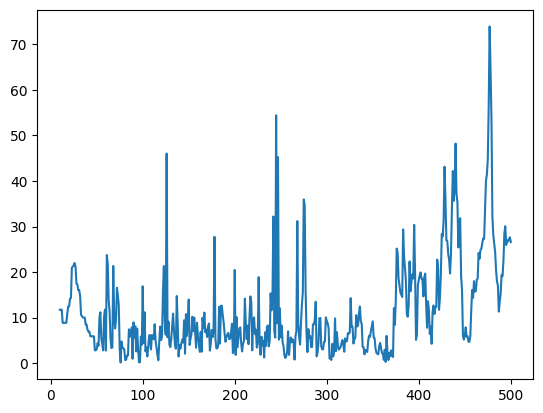

In [8]:
predictions_sp1 = rf.predict(sp_1)
mpl.plot(range, predictions_sp1)

In [9]:
names = encoder.inverse_transform(featurest1)

In [10]:
# create one range for each species. basically just need a list of all species, and what their encodings are.

# get the unique names from names
sp_list = names.sp.unique()
#sp_list = sp_list.to_numpy()
sp_num = np.shape(sp_list)[0]
sp_mat = np.hstack((np.atleast_2d(sp_list).transpose(), (np.zeros((sp_num, 9)))))

# for i in range(sp_num):
    # for each, need to just find the encoding! and append it here!
    # two ways: 
    # 1) look at initial dataset and find the tree with that ID, then find its encoding
    # 2) run through encoder again
    # method 1 used below

    #  id of one tree with that species is provided by names
    # tree_id = np.where(names[:,0] == sp_list[i,0])




TypeError: 'numpy.ndarray' object is not callable